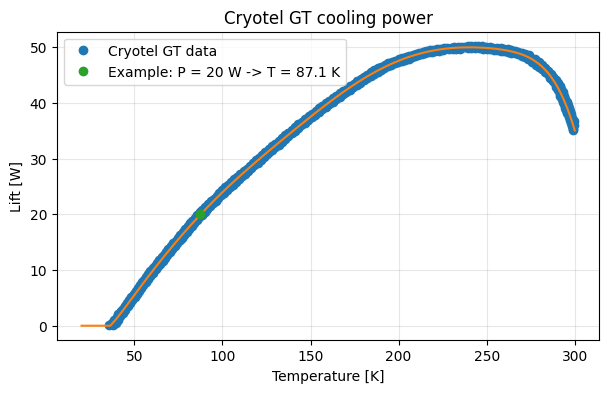

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from cryotherm import DATA_PATH                      # packaged resource
from cryotherm.material_db import MaterialDatabase


# ---------------------------------------------------------------------
# 1)  Material DB  (polylog + tables)
# ---------------------------------------------------------------------
db = MaterialDatabase(DATA_PATH)

# ---------------------------------------------------------------------
# 2)  Fridge load curve  (Cryotel GT)
# ---------------------------------------------------------------------
_FRIDGE_CSV = (DATA_PATH / "fridges" / "CryotelGT.csv")

# read once, build an interpolator that works for scalars *and* arrays
fridge_temp, fridge_lift = np.loadtxt(_FRIDGE_CSV, delimiter=",", unpack=True)

T_MIN, T_MAX = fridge_temp.min(), fridge_temp.max()

# fit a polynomial to the data for fast evaluation
FRIDGE_FIT = np.polyfit(fridge_temp, fridge_lift, 12)  # poly fit


def fridge_curve(T):
    """Cooling power [W] available at temperature T (K).

    • Linear interpolation of the Cryotel GT CSV.
    • Returns 0 outside the tabulated range (below Tmin or above Tmax).
    Handles both scalar and ndarray inputs cleanly.
    """
    T_arr = np.asanyarray(T, dtype=float)
    
    lift = np.polyval(FRIDGE_FIT, T_arr)
    return np.where((T_arr < T_MIN) | (lift < 0.0), 0.0, lift)


# sanity plot
if __name__ == "__main__":
    T_plot = np.linspace(20, 300, 1000)
    plt.figure(figsize=(7, 4))
    # plot the raw data
    plt.plot(fridge_temp, fridge_lift, "o", label="Cryotel GT data")
    plt.plot(T_plot, fridge_curve(T_plot))

    # plot an example point on the curve
    P_example = 20 # W
    # get the temperature where the fridge can lift this power
    T_example = np.interp(P_example, fridge_lift, fridge_temp)
    plt.plot(T_example, P_example, "o", label=f"Example: P = {P_example} W -> T = {T_example:.1f} K")
    plt.title("Cryotel GT cooling power")
    plt.xlabel("Temperature [K]")
    plt.ylabel("Lift [W]")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [47]:
from cryotherm import DATA_PATH                      # packaged resource
from cryotherm.material_db import MaterialDatabase
from cryotherm.stage import Stage
from cryotherm.conduction import Conduction
from cryotherm.radiation import Radiation
from cryotherm.solver import ThermalModel
from cryotherm.fridge import available
from cryotherm.visualize import visualize_model   # or paste the code block once



# Model a single stage with the fridge

inner = Stage("Cold head", 300, fridge_curve="CryotelGT",
              external_load=16, # W
              )       
model = ThermalModel([inner])
model.solve()

print(inner.temperature) 
print(inner._q_in, inner.cooling_power(inner.temperature))

# prints:
# 77.21449739754357
# 16.0 16.00000283800499

# Similar: two stages with the fridge to size the heater

fridge_cold_head = Stage("Fridge cold head", 100, fridge_curve="CryotelGT")

cold_plate = Stage("Cold plate", 100, target_temperature=77.21449739754357,
                   external_load=16.,  # W
                   )

# connect the two stages with conduction
db = MaterialDatabase(DATA_PATH)
heat_strap = Conduction(stage1=fridge_cold_head, stage2=cold_plate,
                        mat_db=db,
                        name = "Heat Strap",
                        type = "cylinder", outer_dia = .00635, length = 0.05, number = 1000,
                        material = "Al6061")

model = ThermalModel(
    stages=[fridge_cold_head, cold_plate],
    conductors=[heat_strap],
    radiators=None,
)

model.solve()

# print results
for s in model.stages:
    print(s.name, s.temperature, "K")
print("Heater power =", cold_plate.external_load(cold_plate.temperature), "W")

# prints:
#Fridge cold head 76.99999994019579 K
#Cold plate 77.0 K
#Heater power = 6.434622985494647e-11 W

77.21449739754357
16.0 16.00000283800499
Fridge cold head 76.91303609126088 K
Cold plate 77.21449739754357 K
Heater power = 16.018664712221288 W


In [56]:
fridge = Stage("Cold head", 300, fridge_curve="CryotelGT")
plate  = Stage("Cold plate", 100,
               target_temperature=77.214497,   # heater-controlled
               external_load=0.0)       # optional known parasitic load

strap  = Conduction(fridge, plate, type="cylinder",
                    outer_dia=0.0635, length=0.05, number=10,
                    material="Al6061", mat_db=db)

model  = ThermalModel([fridge, plate], conductors=[strap])
model.solve()

print("Plate T      =", plate.temperature, "K")
print("Plate heater =", plate.external_load(plate.temperature), "W")
print("Fridge T     =", fridge.temperature, "K")


Plate T      = 77.214497 K
Plate heater = 15.567448478487098 W
Fridge T     = 76.91310055917856 K
